# importing necessary modules

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

# load and preprocess data

In [23]:
# Load the dataset
df = pd.read_csv("/Users/shreya/Desktop/BiGRU_AM/processed_data2.csv")

In [24]:
# Encode categorical columns
label_encoder = LabelEncoder()
df['Region'] = label_encoder.fit_transform(df['Region'])
df['Day_period'] = label_encoder.fit_transform(df['Day_period'])
df['Season'] = label_encoder.fit_transform(df['Season'])
df['Weekday_or_weekend'] = label_encoder.fit_transform(df['Weekday_or_weekend'])
df['Regular_day_or_holiday'] = label_encoder.fit_transform(df['Regular_day_or_holiday'])

# Define features and target including encoded columns
X = df[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene',
               'Region', 'Day_period', 'Month_encoded', 'Season', 'Weekday_or_weekend', 'Regular_day_or_holiday']]
y = df['AQI']

In [25]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X)

# Display the shape of the new feature set
print('Original shape:', X.shape)
print('New shape:', X_pca.shape)


Original shape: (999999, 17)
New shape: (999999, 10)


# train and test split

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Build the ANN model
def create_model(optimizer='adam', neurons=32, dropout_rate=0.0, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Assuming regression problem with single output
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [27]:
# model = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    'batch_size': [32],  # Single batch size for faster training
    'epochs': [10, 15, 20],  # Reduced number of epochs
    'model__optimizer': ['Adam'],  # Single optimizer
    'model__neurons': [16, 32, 64],  # Reduced number of neurons
    'model__dropout_rate': [0.2, 0.3],  # Dropout rate
    'model__activation': ['relu', 'tanh']  # Activation functions
}

model = KerasRegressor(model=create_model, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


KeyboardInterrupt: 

In [ ]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [28]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model creation function
def create_model(neurons=32, dropout_rate=0.2, optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Keras wrapper for scikit-learn
model = KerasRegressor(model=create_model, verbose=0)

# Hyperparameter grid
param_grid = {
    'batch_size': [32, 64],  # Added another batch size
    'epochs': [20, 30],  # Increased epochs
    'model__optimizer': ['Adam', 'RMSprop'],  # Added another optimizer
    'model__neurons': [32, 64, 128],  # Increased neurons
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Added another dropout rate
    'model__activation': ['relu', 'tanh', 'elu']  # Added another activation function
}

# Grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Shift target values for training
shift = abs(min(np.min(y_train), np.min(y_test))) + 1
y_train_shifted = y_train + shift
y_test_shifted = y_test + shift

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, min_lr=0.001)

# Best model training with early stopping and learning rate reduction
best_model = grid_result.best_estimator_
history = best_model.fit(X_train, y_train_shifted, validation_split=0.3, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

# Predictions and shift back
y_pred_shifted = best_model.predict(X_test)
y_pred = y_pred_shifted - shift

# Metrics calculation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
r2 = r2_score(y_test, y_pred)
msle = mean_squared_log_error(y_test_shifted, y_pred_shifted)

print("R² (Coefficient of Determination):", r2)
print("MAE (Mean Absolute Error):", mae)
print("MAPE (Mean Absolute Percentage Error):", mape)
print("RMSE (Root Mean Square Error):", rmse)
print("MSLE (Mean Squared Logarithmic Error):", msle)


/Users/shreya/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/shreya/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/shreya/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=

Best: 0.870826 using {'batch_size': 64, 'epochs': 30, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__neurons': 128, 'model__optimizer': 'Adam'}
Epoch 1/50


/Users/shreya/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15313/15313 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 0.5236 - val_loss: 0.1603
Epoch 2/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.2031 - val_loss: 0.1535
Epoch 3/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.1935 - val_loss: 0.1472
Epoch 4/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.1859 - val_loss: 0.1469
Epoch 5/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.1820 - val_loss: 0.1412
Epoch 6/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.1792 - val_loss: 0.1385
Epoch 7/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.1779 - val_loss: 0.1379
Epoch 8/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.1774 - val_loss: 0.1365
Epoch 9/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.1745 - val_loss: 0.1361
Epoch 10/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.1739 - val_loss: 0.1335
Epoch 11/50
15313/15313 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.1739 - val_loss: 0.1327
Epoch 12

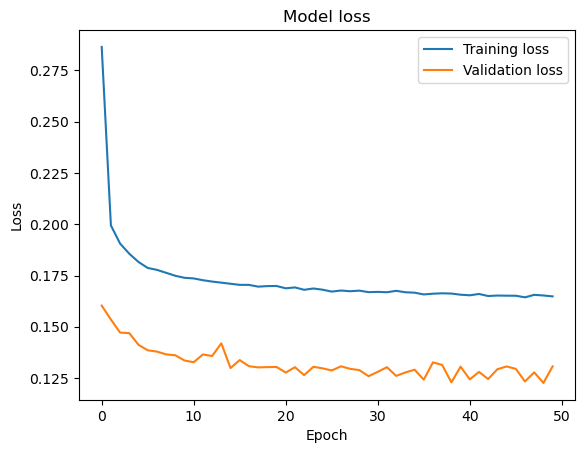

In [29]:
# Access the training history
history = best_model.history_

# Plot the training and validation loss
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
